In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd
import power_laws
import rubisco_data

from scipy import stats
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Want to split data in various ways
# Savir vs. Non-Savir (mostly new) data
savir_pmid = '20142476'
savir_df = raw_kin_df[raw_kin_df.pmid_or_doi == savir_pmid]
nonsavir_df = raw_kin_df[raw_kin_df.pmid_or_doi != savir_pmid]

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

Simple sanity check of the inferred parameters - $k_{cat,O}$, $k_{cat,O}/K_O$, $k_{cat,C}/K_C$. These parameters are inferred from measurements. In the case of $k_{cat,O}$ we check the inference by recalculating $S_{C/O}$ from the other parameters including $k_{cat,O}$ and comparing that to the bootstrapped value and CI. In the other cases we simply compare the bootstrapped mean and CI to the straightforward calculation. 

Note that for legacy reasons this code and the files produced use the nomenclature of Savir et al. 2010 while the paper uses more standard biochemical nomenclature. For this reason you see $v_C$ and $v_O$ for $k_{cat,O}$ and $k_{cat,O}$ here. You will also see $S = S_{C/O}$ since it can be used as a variable name in python.

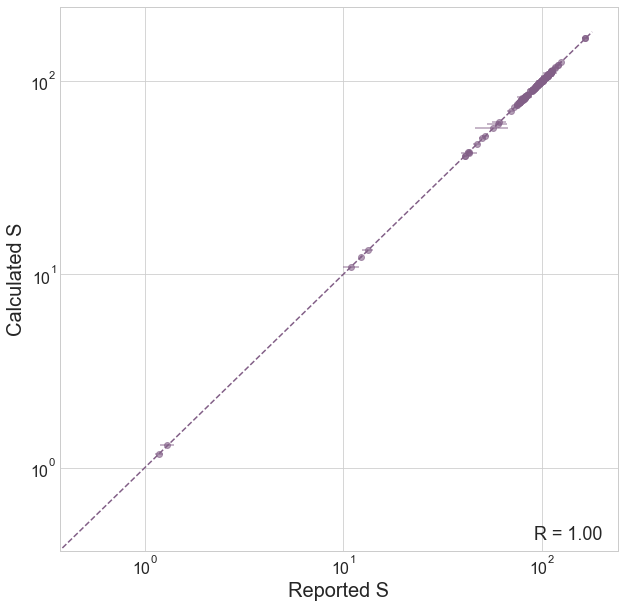

In [3]:
# Testing that bootstrapped S values match calculation from remaining parameters.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

inferred_S = kin_df.vC * kin_df.KO / (kin_df.vO * kin_df.KC)
plt.errorbar(kin_df.S, inferred_S, xerr=kin_df.S_SD, c=named_colors[3], alpha=0.6, ls='', marker='o')

xs = np.arange(0, 180, 0.5)
plt.plot(xs, xs, ls='--', color=named_colors[3])
plt.text(0.85, 0.02, 'R = %.2f' % power_laws.log_pearsonr(np.log(kin_df.S), np.log(inferred_S))[0], 
         transform=figure.axes[0].transAxes, fontsize=18)

plt.xlabel('Reported S', fontsize=20)
plt.ylabel('Calculated S', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

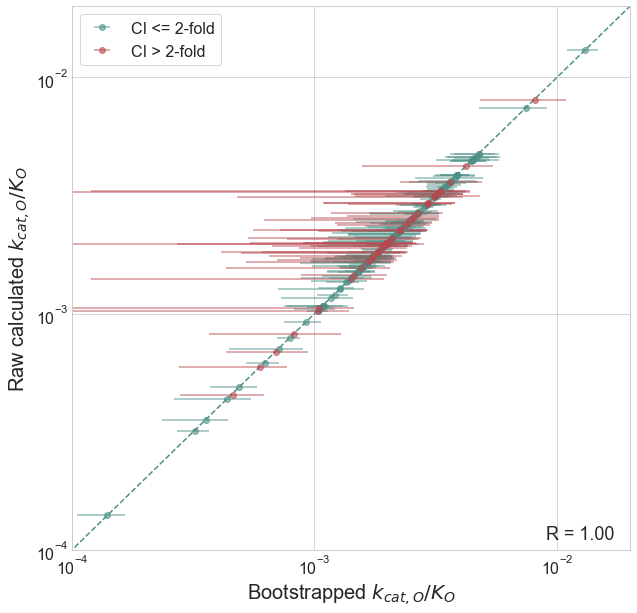

In [4]:
# Testing that bootstrapped kcat,O/KO values match calculation from remaining parameters.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

inferred_kon_O = kin_df.vO / kin_df.KO

xerr = np.vstack([kin_df.kon_O_95CI_high - kin_df.kon_O, 
                  kin_df.kon_O - kin_df.kon_O_95CI_low])
err_width = kin_df.kon_O_95CI_high / kin_df.kon_O_95CI_low
high_err = err_width > 2.0
low_err = np.logical_not(high_err)

plt.errorbar(kin_df.loc[low_err].kon_O, inferred_kon_O.loc[low_err], xerr=xerr[:, low_err],
             c=named_colors[4], alpha=0.6, ls='', marker='o', label='CI <= 2-fold')
plt.errorbar(kin_df.loc[high_err].kon_O, inferred_kon_O.loc[high_err], xerr=xerr[:, high_err],
             c=named_colors[5], alpha=0.6, ls='', marker='o', label='CI > 2-fold')

xs = np.arange(3e-5, 3e-2, 0.01)
plt.plot(xs, xs, ls='--', color=named_colors[4])
plt.text(0.85, 0.02, 'R = %.2f' % power_laws.log_pearsonr(np.log(kin_df.kon_O), np.log(inferred_kon_O))[0], 
         transform=figure.axes[0].transAxes, fontsize=18)

plt.xlabel('Bootstrapped $k_{cat,O} / K_O$', fontsize=20)
plt.ylabel('Raw calculated $k_{cat,O} / K_O$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlim(1e-4, 2e-2)
plt.ylim(1e-4, 2e-2)

plt.show()

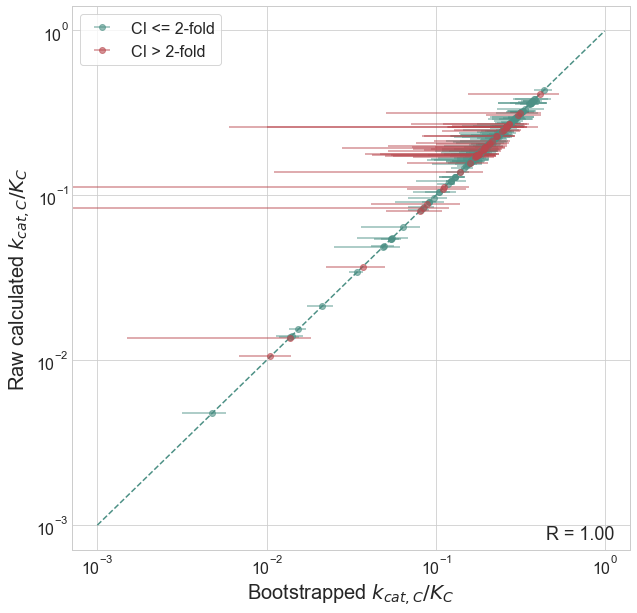

In [5]:
# Testing that bootstrapped kcat,C/KC values match calculation from remaining parameters.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

inferred_kon_C = kin_df.vC / kin_df.KC

xerr = np.vstack([kin_df.kon_C_95CI_high - kin_df.kon_C, 
                  kin_df.kon_C - kin_df.kon_C_95CI_low])
err_width = kin_df.kon_C_95CI_high / kin_df.kon_C_95CI_low
high_err = err_width > 2.0
low_err = np.logical_not(high_err)

plt.errorbar(kin_df.loc[low_err].kon_C, inferred_kon_C.loc[low_err], xerr=xerr[:, low_err],
             c=named_colors[4], alpha=0.6, ls='', marker='o', label='CI <= 2-fold')
plt.errorbar(kin_df.loc[high_err].kon_C, inferred_kon_C.loc[high_err], xerr=xerr[:, high_err],
             c=named_colors[5], alpha=0.6, ls='', marker='o', label='CI > 2-fold')

xs = np.arange(1e-3, 1.0, 0.01)
plt.plot(xs, xs, ls='--', color=named_colors[4])
plt.text(0.85, 0.02, 'R = %.2f' % power_laws.log_pearsonr(np.log(kin_df.kon_O), np.log(inferred_kon_O))[0], 
         transform=figure.axes[0].transAxes, fontsize=18)

plt.xlabel('Bootstrapped $k_{cat,C} / K_C$', fontsize=20)
plt.ylabel('Raw calculated $k_{cat,C} / K_C$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc=2, fontsize=16, frameon=True)

plt.show()

Simple sanity check specific to $k_{cat,O}$. We calculate $k_{cat,O}$ from the other parameters uniformly using a bootstrapping procedure since $k_{cat,O}$ is almost always inferred from the measurements and we wanted to use a uniform inference procedure. Here we compare the calculated values to those reported in the literature references. 

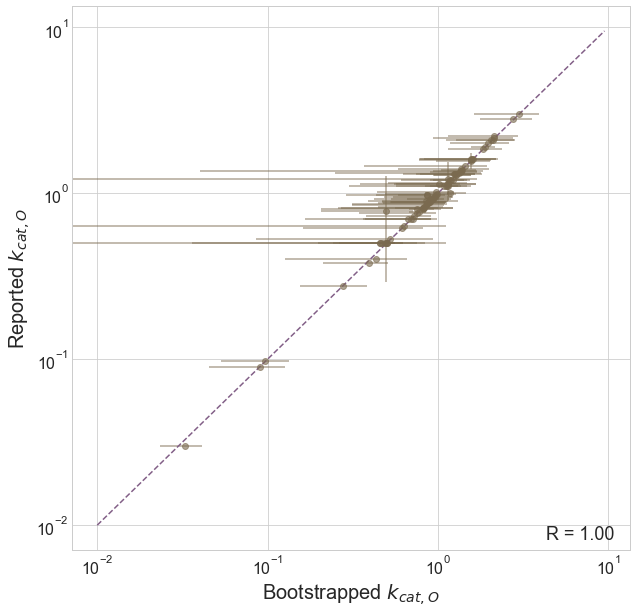

In [6]:
# Testing that literature k_cat,O values match bootstrapping from remaining parameters.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

xerr = np.vstack([kin_df.vO_95CI_high - kin_df.vO, 
                  kin_df.vO - kin_df.vO_95CI_low])
plt.errorbar(kin_df.vO, kin_df.vO_reported, xerr=xerr, yerr=kin_df.vO_SD_reported,
             c=named_colors[2], alpha=0.6, ls='', marker='o')

xs = np.arange(1e-2, 10, 0.5)
plt.plot(xs, xs, ls='--', color=named_colors[3])
plt.text(0.85, 0.02, 'R = %.2f' % power_laws.log_pearsonr(np.log(kin_df.vO), np.log(kin_df.vO_reported))[0], 
         transform=figure.axes[0].transAxes, fontsize=18)

plt.xlabel('Bootstrapped $k_{cat,O}$', fontsize=20)
plt.ylabel('Reported $k_{cat,O}$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

Notice above that the correlation between reports and our calculation is very strong (R ~= 1.0). However some outliers are visible. Here we take a look at the deviation between our calculations and the literature reports for $k_{cat,O}$. The biggest outlier (~37% error) is the report for P. marinus from Shih et al. 2016, which appears to be a calculation error on their part. Their methods section reports that they calculate $k_{cat,O}$ in the usual manner, but performing this calculation on their data gives a value of 0.49 similar to what was calculated by our scripts. 

Similarly, the value for F. pringlei from Whitney et al. 2011 has 18% error. Reviewing their table it appears to be another calculation error on their part. 

In [7]:
# Take a look at the biggest outliers. 
abs_diff = np.abs(kin_df.vO - kin_df.vO_reported)
pct_diff = 100*abs_diff / kin_df.vO_reported
copy_kin_df = kin_df.copy()
copy_kin_df['abs_diff'] = abs_diff
copy_kin_df['pct_diff'] = pct_diff
sorted_df = copy_kin_df.sort_values('pct_diff', ascending=False)
cols = ['species', 'identifier', 'abs_diff', 'pct_diff', 'vO', 'vO_95CI_high', 'vO_95CI_low', 'vO_reported', 'vO_SD_reported']
sorted_df[cols].head(10)

,species,identifier,abs_diff,pct_diff,vO,vO_95CI_high,vO_95CI_low,vO_reported,vO_SD_reported
225,Prochlorococcus marinus MIT9313,marinus_shih,0.2850,36.538462,0.4950,0.7840,0.2740,0.78,0.49
235,Flaveria pringlei,pringlei_whitney,0.1800,18.000000,1.1800,1.5200,0.8940,1.00,NaN
158,Aegilops uniaristata,uniaristata_prins,0.1130,11.530612,0.8670,1.3000,0.6270,0.98,NaN
169,Aegilops speltoides,speltoides_prins,0.1100,11.340206,0.8600,1.4300,0.5930,0.97,NaN
172,T. timonovum,timonovum_prins,0.1200,10.526316,1.0200,1.6900,0.6980,1.14,NaN
0,Methanococcoides burtonii,burtonii_coli_alonso,0.0027,9.000000,0.0327,0.0421,0.0243,0.03,NaN
245,Phaeodactylum tricornutum (CS-29),tricornutumCS29_young,0.0450,9.000000,0.4550,0.6490,0.2850,0.50,NaN
241,Chaetoceros muelleri (CCMP 1316),muelleri_young,0.0420,8.400000,0.4580,0.6730,0.2900,0.50,NaN
248,Thalassiosira oceania (CS-427),oceania_young,0.0310,7.750000,0.4310,0.7360,0.2050,0.40,NaN
242,Chaetoceros calcitrans (CCMP 1315),calcitransCCMP1315_young,0.0470,5.875000,0.7530,1.3000,0.4670,0.80,NaN


In [8]:
sorted_df.columns

Index(['species', 'identifier', 'primary', 'mutant', 'heterologous_expression',
       'KC', 'KC_SD', 'vC', 'vC_SD', 'S', 'S_SD', 'KO', 'KO_SD', 'vO',
       'vO_95CI_low', 'vO_95CI_high', 'vO_reported', 'vO_SD_reported', 'kon_C',
       'kon_C_95CI_low', 'kon_C_95CI_high', 'kon_O', 'kon_O_95CI_low',
       'kon_O_95CI_high', 'KRuBP', 'KRuBP_SD', 'temp_C', 'pH', 'isoform',
       'taxonomy', 'note', 'short_ref', 'pmid_or_doi', 'citation', 'abs_diff',
       'pct_diff'],
      dtype='object')